<a href="https://colab.research.google.com/github/nedokormysh/GB_ML_business/blob/lesson3/ML_business_hw_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-2

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2023-02-02 08:47:35--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 74.125.69.138, 74.125.69.139, 74.125.69.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.69.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c815ecc88q7k17f4f2af8mcoelm9gpmu/1675327650000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=200b22fb-052d-4a37-9226-615b1cb6c400 [following]
--2023-02-02 08:47:36--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c815ecc88q7k17f4f2af8mcoelm9gpmu/1675327650000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=200b22fb-052d-4a37-9226-615b1cb6c400
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 173.194.192.132, 2607:f8b

In [3]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=42)

<ipython-input-4-ebc23ba02415>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.09144178,  0.44594423,  0.05752649, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46216539,  0.20194394, -0.84752919, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.5702846 , -1.01805752,  1.79801819, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67238553,  0.56794437, -0.01209318, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50009534,  0.32394408, -0.29057185, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76136594,  1.54394554, -0.70828985, ...,  0.        ,
         0.        ,  1.        ]])

In [7]:
def scores_for_classifier(classifier, roc: bool, pr_rec: bool, all_drw=False):
    
    # Cross Val
    
    cv_scores = cross_val_score(classifier, X_train, y_train, cv = 16, scoring = 'roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    
    # Use train data for learning
    
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    

    if roc == True:
      sns.set(font_scale=1.5)
      sns.set_color_codes("muted")

      plt.figure(figsize=(6, 6))
      fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
      lw = 2
      plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
      plt.plot([0, 1], [0, 1])
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC curve')

    if pr_rec == True:
      sns.set(font_scale=1.5)
      sns.set_color_codes("muted")

      plt.figure(figsize=(6, 6))
      prec_, rec_, thresholds__ = precision_recall_curve(y_test, y_score, pos_label=1)
      
      lw = 2
      plt.plot(rec_, prec_, lw=lw, label='Precision Recall curve ')

      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.title('Precision Recall curve')
      

    if all_drw == True:

      fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
      roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

      prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=1)
      pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()


    # Metrics
    
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    roc = roc_auc_score(y_test, y_score)
    ix = np.argmax(fscore)


    
    return [round(i, 3) for i in [cv_score, cv_score_std, thresholds[ix], fscore[ix], precision[ix], recall[ix], roc]]

## Logreg

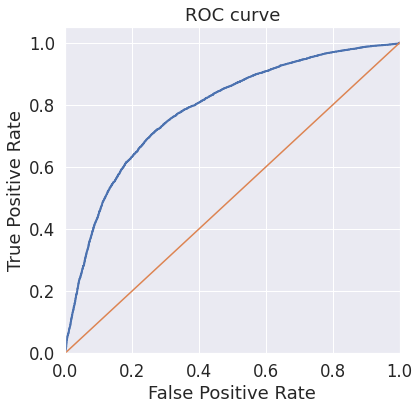

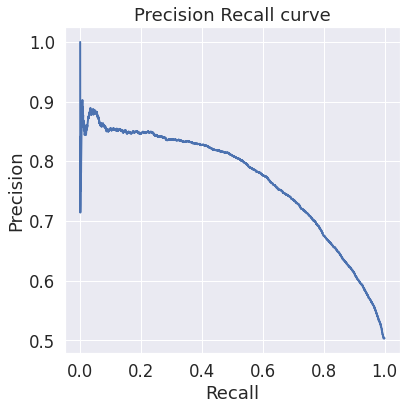

In [8]:
cv_score, cv_score_std, thr, fscore, precision, recall, roc = scores_for_classifier(classifier = Pipeline([
    ('features', feats), ('classifier', LogisticRegression(random_state = 42))]), roc=True, pr_rec=True)

In [9]:
# создадим датафрейм для сбора всех результатов в таблицу
df_results = pd.DataFrame(columns=['model', 'cv_score',  'cv_score_std', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
df_results

,model,cv_score,cv_score_std,thresh,F-Score,Precision,Recall,ROC AUC


In [10]:
df_results.loc[len(df_results.index)] = ['Log Reg', cv_score, cv_score_std, thr, fscore, precision, recall, roc]

# df_results

## Random Forrest

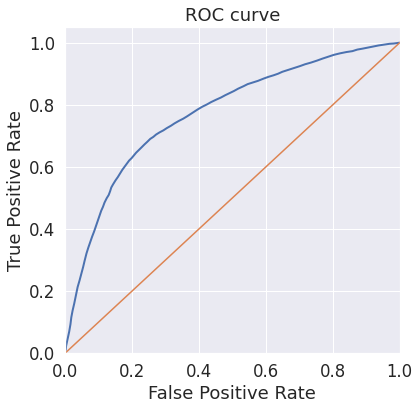

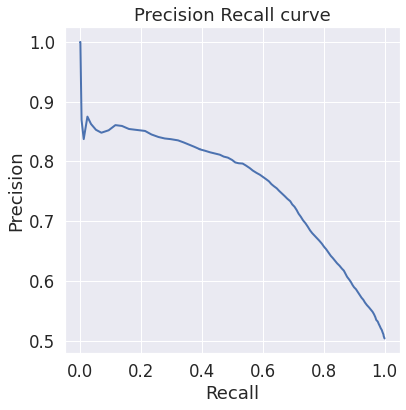

In [11]:
from sklearn.ensemble import RandomForestClassifier

cv_score, cv_score_std, thr, fscore, precision, recall, roc = scores_for_classifier(classifier = Pipeline([
    ('features', feats), ('classifier', RandomForestClassifier(random_state = 42))]), roc=True, pr_rec=True)

In [12]:
df_results.loc[len(df_results.index)] = ['Random Forrest', cv_score, cv_score_std, thr, fscore, precision, recall, roc]

# df_results

## GradientBoostingClassifier

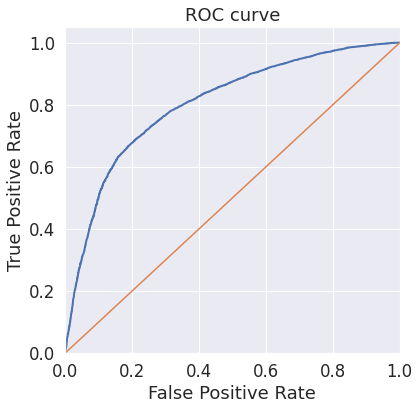

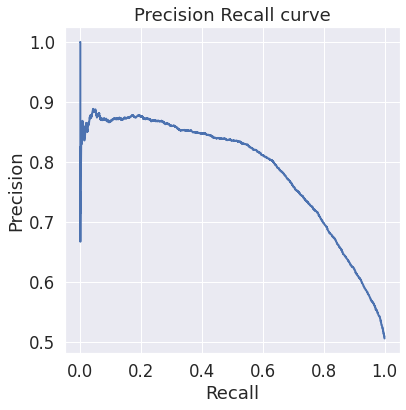

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

cv_score, cv_score_std, thr, fscore, precision, recall, roc = scores_for_classifier(classifier = Pipeline([
    ('features', feats), ('classifier', GradientBoostingClassifier(random_state = 42))]), roc=True, pr_rec=True)

In [14]:
df_results.loc[len(df_results.index)] = ['GradientBoosting', cv_score, cv_score_std, thr, fscore, precision, recall, roc]

# df_results

## AdaBoostClassifier

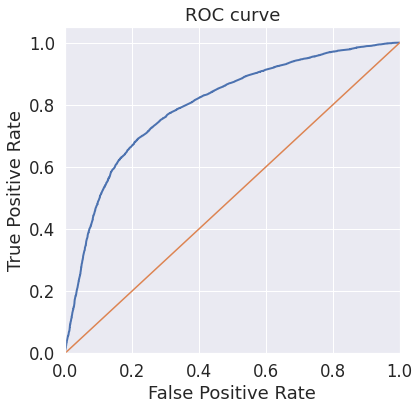

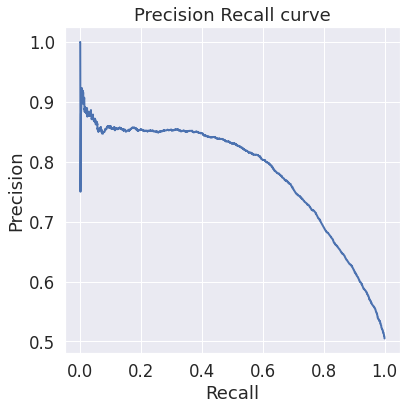

In [15]:
from sklearn.ensemble import AdaBoostClassifier

cv_score, cv_score_std, thr, fscore, precision, recall, roc = scores_for_classifier(classifier = Pipeline([
    ('features', feats), ('classifier', AdaBoostClassifier(random_state = 42))]), roc=True, pr_rec=True)

In [16]:
df_results.loc[len(df_results.index)] = ['AdaBoost', cv_score, cv_score_std, thr, fscore, precision, recall, roc]

# df_results

# 3
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [17]:
df_results

,model,cv_score,cv_score_std,thresh,F-Score,Precision,Recall,ROC AUC
0,Log Reg,0.782,0.010,0.397,0.735,0.656,0.837,0.785
1,Random Forrest,0.775,0.009,0.370,0.722,0.653,0.809,0.772
2,GradientBoosting,0.802,0.009,0.411,0.746,0.716,0.780,0.803
3,AdaBoost,0.795,0.009,0.498,0.743,0.715,0.773,0.798


# 4

4. сделать выводы о том, какая модель справилась с задачей лучше других

Модель градиентного бустинга с данными параметрами показала лучшие результаты и по f-score и roc auc. При этом по recall характеристикам модели случайного леса и логистической регрессии выдали скор лучше.

# 5

5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

В случае сильного дисбаланса классов лучше подходит precision_recall_curve.

TPR и recall являются одним и тем же, следовательно, различие между двумя характеристиками следует рассматривать в FPR и precision.

$FPR = \frac{FP}{FP+TN}$

$precision(a, X) = \frac{TP}{TP+FP}$

В несбалансированных классах, будем предполагать, что у нас событие, которые мы ищем - редкое. Тогда TN вероятнее всего будет относительно большим числом. Следовательно независимо от FP характеристика FPR будет сильно зависеть от TN. Precision же, в свою очередь, не связан с TN и, таким образом, будет сильно зависеть от FP.

В примере, разница от влияния изменения FPR в первом и во втором случае на порядки меньше, чем изменение precision. Всё из-за учёта TN, который всегда будет очень большим для несбалансированных классов. И по формуле стоит в знаменателе.

In [18]:
# n = 100_000 T = 100 N = 99_900

# 1 
# n_1 = 100
TP = 90
FP = 10
FN = 10
TN = 99890

precision_1 = TP / (TP + FP)
FPR_1 = FP / (FP + TN)

#2
# n_2 = 1000
TP = 90
FP = 910
FN = 10
TN = 98990

precision_2 = TP / (TP + FP)
FPR_2 = FP / (FP + TN)

print('\033[1m' + 'Первый пример' + '\033[0m')
print(f'Precision 1 = {precision_1}, FPR 1 = {FPR_1}')
print('\033[1m' + 'Второй пример' + '\033[0m')
print(f'Precision 2 = {precision_2}, FPR 2 = {FPR_2}')
print('-' * 10)
print(f'Разница между precision 2 и precision 1 = {precision_2 - precision_1}')
print(f'Разница между FPR 2 и FPR 1 = {round(FPR_2 - FPR_1, 3)}')

Первый пример
Precision 1 = 0.9, FPR 1 = 0.0001001001001001001
Второй пример
Precision 2 = 0.09, FPR 2 = 0.00910910910910911
----------
Разница между precision 2 и precision 1 = -0.81
Разница между FPR 2 и FPR 1 = 0.009


# 6

6. (опциональный вопрос) Найти порог классификации по деньгам (Стоимость лечения 15000 р, если сделали тест и начали лечить вовремя. Стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы. Стоимость теста 1400 р)

In [19]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [20]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b**2)*(precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.410948, F-Score=0.746, Precision=0.716, Recall=0.780


In [100]:
def business_threshold_calibrate(y_test, y_score, thresholds, rubl_to_test = 100, rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = ((cnf_matrix[1][1]+cnf_matrix[1][0])) * rubl_to_late_treatment

        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        rubl_ML = ((cnf_matrix[1][1]+cnf_matrix[0][1])) * rubl_to_test + np.sum(cnf_matrix[1][0]) * rubl_to_late_treatment + (cnf_matrix[1][1]) * rubl_to_early_treatment
       
        r2_r3 = rubl_all_test - rubl_ML 
        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        #print(opt_buisness_tr, r2_r3)
        if (r2_r3_ < r2_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1_)
    print('расходы, если делать тест всем и лечить группу большых:', rubl_all_test_)
    print('расходы, если не делать тест и ждать симптомов:', rubl_ML_)
    print('Расходы при решении не делать тесты - расходы с МL :', r1_r3_ )
    print('Расходы при решении не делать тесты - расходы ссделать тесты всем  :', r1_r2_ )
    print('Расходы сделать тесты всем - решение делать тесты ML  :', r2_r3_ )
    plt.figure(figsize=(8, 5))
    plt.plot(np.linspace(0, 1, n), r2)
    plt.vlines(business_threshold, -2e7, 4e6, color = 'g', label=f'best business threshold = {round(business_threshold, 3)}')
    plt.legend(fontsize=13)   
    plt.grid('On')
    plt.show()
    return business_threshold

расходы, если не делать тест и ждать симптомов: 176240000
расходы, если делать тест всем и лечить группу большых: 156680000
расходы, если не делать тест и ждать симптомов: 154489400
Расходы при решении не делать тесты - расходы с МL : 21750600
Расходы при решении не делать тесты - расходы ссделать тесты всем  : 19560000
Расходы сделать тесты всем - решение делать тесты ML  : 2190600


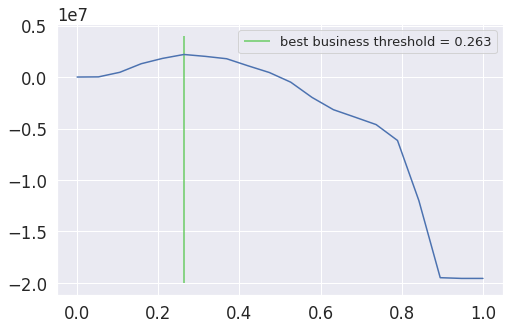

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.4109475258556618


In [101]:
Business_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)

print('уровень порога по бизнес метрике',Business_tr)
print('уровень порога по f1 метрике',thresholds[ix])